In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
import seaborn as sns
import warnings
import datetime as dt
from datetime import timedelta
warnings.filterwarnings('ignore')
sns.set()

## 5C.1 Feature Selection

In [2]:
%store -r feature_sarima

In [3]:
# As we have seen in the second model
# Although having mean that is very close to zero
# The train residuals do not closely follow normal distribution
# Therefore, this time we try using Box-Cox transformation on the target

transformed_data, lambda_value = stats.boxcox(feature_sarima['resale_price'])
feature_sarima['resale_price'] = transformed_data
reverse_transformation = lambda y: np.power((y*lambda_value + 1), (1/lambda_value)) # this function to reverse the transformation later on


In [4]:
# create a combination of feature
# we use the same features as those in second model

feat = feature_sarima.drop(['resale_quarter','resale_month', 'resale_year','lag1', 'lag2', 'lag4', 'sarima_forecast'], axis = 1)
feat.shape

# Here we have 10 variables, including the target

(152529, 9)

In [5]:
feat.head()

,resale_price,resale_date,lease_commence_year,storey_range,town,flat_model,floor_area_sqm,lag3,trend
7925,7.473011,2017-06-01,1986,2,ANG MO KIO,IMPROVED,45.0,447295.950889,444038.092571
7926,7.496209,2017-06-01,1978,2,ANG MO KIO,IMPROVED,44.0,447295.950889,444038.092571
7927,7.475834,2017-06-01,1976,2,ANG MO KIO,NEW GENERATION,67.0,447295.950889,444038.092571
7928,7.509065,2017-06-01,1980,2,ANG MO KIO,NEW GENERATION,68.0,447295.950889,444038.092571
7929,7.509065,2017-06-01,1981,0,ANG MO KIO,NEW GENERATION,68.0,447295.950889,444038.092571


## 5C.2 Model Building

In [6]:
dummies = pd.get_dummies(feat, drop_first= True, prefix_sep= '.') #create dummy variables
dummies.head()

# reference categories:
## town: 'ANG MO KIO'
## flat_model: '2-ROOM'

,resale_price,resale_date,lease_commence_year,storey_range,floor_area_sqm,lag3,trend,town.BEDOK,town.BISHAN,town.BUKIT BATOK,...,flat_model.MULTI GENERATION,flat_model.NEW GENERATION,flat_model.PREMIUM APARTMENT,flat_model.PREMIUM APARTMENT LOFT,flat_model.PREMIUM MAISONETTE,flat_model.SIMPLIFIED,flat_model.STANDARD,flat_model.TERRACE,flat_model.TYPE S1,flat_model.TYPE S2
7925,7.473011,2017-06-01,1986,2,45.0,447295.950889,444038.092571,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7926,7.496209,2017-06-01,1978,2,44.0,447295.950889,444038.092571,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7927,7.475834,2017-06-01,1976,2,67.0,447295.950889,444038.092571,0,0,0,...,0,1,0,0,0,0,0,0,0,0
7928,7.509065,2017-06-01,1980,2,68.0,447295.950889,444038.092571,0,0,0,...,0,1,0,0,0,0,0,0,0,0
7929,7.509065,2017-06-01,1981,0,68.0,447295.950889,444038.092571,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [7]:
feature_sarima.groupby('resale_year').size().cumsum() / len(feature_sarima) * 100

# we use the same train-test split as that in baseline model

resale_year
2017      8.133535
2018     22.257407
2019     36.786447
2020     52.060264
2021     71.101889
2022     88.600201
2023    100.000000
dtype: float64

In [8]:
# Here I pick Aug 2022 as the limit of train dataset (1 year before the last date)
# Which is close to 80:20 split

cutoff_date = 'Aug 2022'
filter_year = dummies['resale_date'] <= cutoff_date
dummies = dummies.drop(['resale_date'], axis = 1) #drop resale_date because it is unusable in the model
train = dummies[filter_year] # training dataset
test = dummies[~filter_year] # testing dataset

In [9]:
len(test)/len(train)

0.20816006463417533

In [10]:
X_train = train.iloc[:, 1:] # training predictors
X_test = test.iloc[:, 1:] # testing predictors
y_train = train.iloc[:, 0] # training target
y_test = test.iloc[:, 0] # testing target

In [11]:
import statsmodels.api as sm

LinearRegression = sm.OLS(y_train, sm.add_constant(X_train)).fit()
LR_summary = LinearRegression.summary()
print(LR_summary)

# From the summary below, we get the R-squared of 89.8%, higher than that of second model
# The predictors p-values also indicate that those feature are mostly statistically significant

                            OLS Regression Results                            
Dep. Variable:           resale_price   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                 2.177e+04
Date:                Mon, 30 Oct 2023   Prob (F-statistic):               0.00
Time:                        10:31:19   Log-Likelihood:             2.4949e+05
No. Observations:              126249   AIC:                        -4.989e+05
Df Residuals:                  126198   BIC:                        -4.984e+05
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

## 5C.3 Visual Evaluation

In [12]:
# create prediction based on training dataset
y_train_pred = LinearRegression.predict(sm.add_constant(X_train))
y_train_pred_df = pd.concat([feature_sarima['resale_date'], y_train_pred], axis = 1)

In [13]:
# create prdiction based on testing dataset
y_test_pred = LinearRegression.predict(sm.add_constant(X_test))
y_test_pred_df = pd.concat([feature_sarima['resale_date'], y_test_pred], axis = 1)

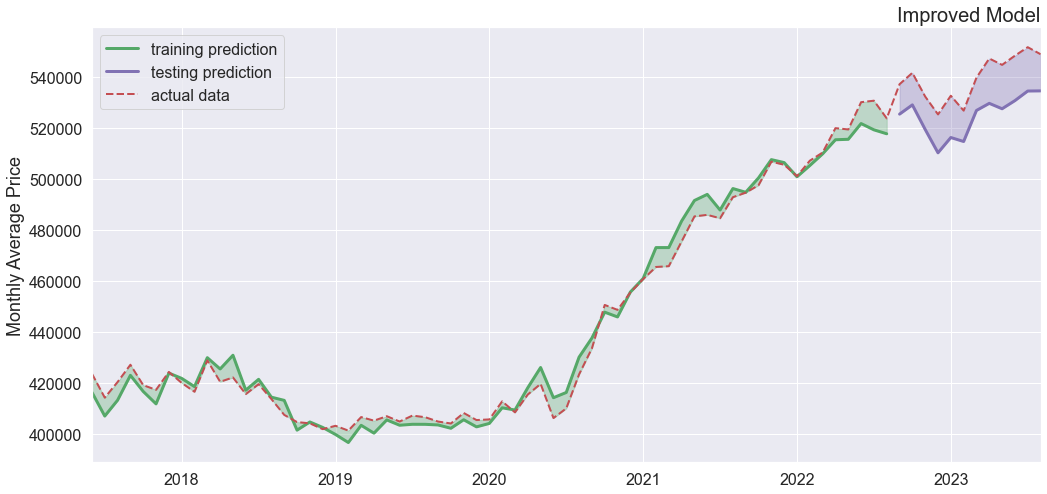

In [14]:
# Compare the training and testing predictions with actual dataset
fontsize1 = 20
fontsize2 = 16
alpha = 0.3

plot1 = y_train_pred_df.groupby('resale_date')[0].mean().apply(reverse_transformation)
plot2 = y_test_pred_df.groupby('resale_date')[0].mean().apply(reverse_transformation)
plot3 = feature_sarima.groupby('resale_date')['resale_price'].mean().apply(reverse_transformation)


plt.figure(figsize=[17,8])
plot1.plot(color = 'g', label = 'training prediction', linewidth = 3)
plot2.plot(color = 'm', label = 'testing prediction', linewidth = 3)
plot3.plot(color = 'r', label = 'actual data', linestyle = '--', linewidth = 2)

plt.fill_between(plot3.index, plot1, plot3, color = 'g', alpha = alpha)
plt.fill_between(plot3.index, plot2, plot3, color = 'm', alpha = alpha)

plt.legend(fontsize = fontsize2)
plt.title('Improved Model', fontsize = fontsize1, loc = 'right')

plt.xlabel('', fontsize = fontsize2)
plt.ylabel('Monthly Average Price', fontsize = fontsize2+2)

plt.xticks(fontsize = fontsize2)
plt.yticks(fontsize = fontsize2)
plt.savefig('Improved Model Graph.png');

# From the graph below, we can tell that our second model can capture trend and seasonality well
# Although the test prediction exhibits larger errors than train prediction does

In [15]:
# to assess the residuals, we need to studentized the residual values first

train_residual = y_train_pred - y_train
train_residual = train_residual/train_residual.std()
test_residual = y_test_pred - y_test
test_residual = test_residual/test_residual.std()

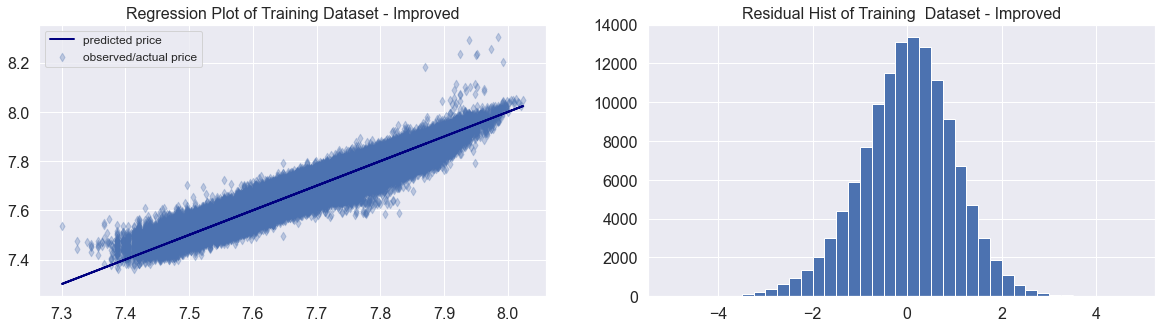

In [16]:
plt.figure(figsize = [20,5])

plt.subplot(1,2,1)
plt.scatter(y_train, y_train_pred, marker = 'd', alpha = 0.3, label = 'observed/actual price')
plt.plot(y_train, y_train, linewidth = 2, label = 'predicted price', color = 'navy')
plt.title('Regression Plot of Training Dataset - Improved', fontsize = fontsize1-4)
plt.legend(fontsize = fontsize2-4)
plt.xticks(fontsize = fontsize2)
plt.yticks(fontsize = fontsize2)

plt.subplot(1,2,2)
bins = np.arange(-5,5,0.25)
plt.hist(train_residual, bins = bins)
plt.title('Residual Hist of Training  Dataset - Improved', fontsize = fontsize1-4)
plt.xticks(fontsize = fontsize2)
plt.yticks(fontsize = fontsize2)

plt.savefig('Residual - Improved.png');

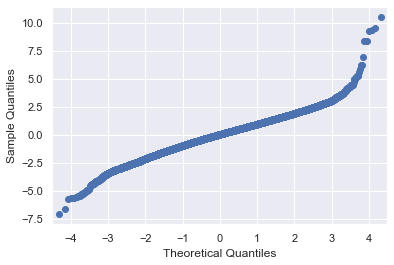

In [17]:
sm.qqplot(train_residual);

In [18]:
train_residual.mean()

#close to zero

2.575709974839765e-11

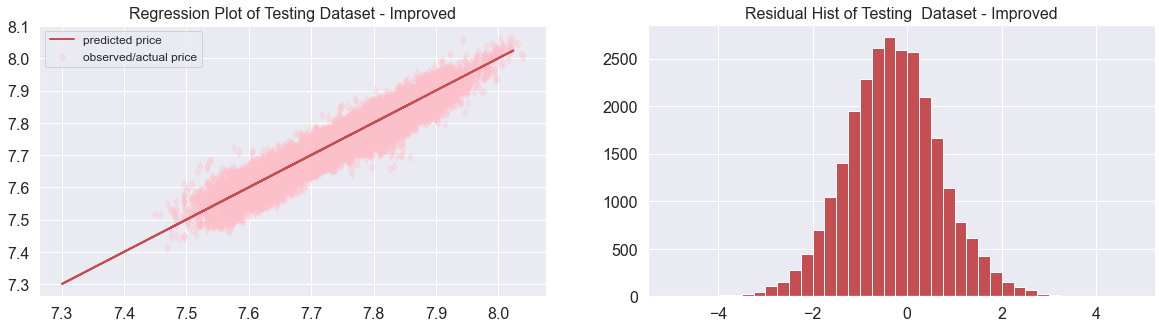

In [19]:
plt.figure(figsize = [20,5])

plt.subplot(1,2,1)
plt.scatter(y_test, y_test_pred, marker = 'd', alpha = 0.3, label = 'observed/actual price', color = 'pink')
plt.plot(y_train, y_train, linewidth = 2, label = 'predicted price', color = 'r')
plt.title('Regression Plot of Testing Dataset - Improved', fontsize = fontsize1-4)
plt.legend(fontsize = fontsize2-4)
plt.xticks(fontsize = fontsize2)
plt.yticks(fontsize = fontsize2)

plt.subplot(1,2,2)
plt.hist(test_residual, bins = bins, color = 'r')
plt.title('Residual Hist of Testing  Dataset - Improved', fontsize = fontsize1-4)
plt.xticks(fontsize = fontsize2)
plt.yticks(fontsize = fontsize2)

plt.savefig('Residual Test - Improved.png');

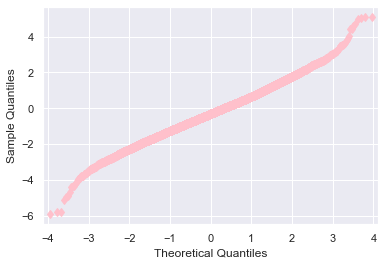

In [20]:
sm.qqplot(test_residual, marker = 'd', markerfacecolor = 'pink', markeredgecolor = 'pink');

In [21]:
test_residual.mean()

#closer to zero than that of baseline model

-0.2979792911110472

## 5C.4 Metrics Evaluation

### 5C.4.1 Regression Metrics

In [22]:
print(f'R-Squared = {LinearRegression.rsquared*100:.3f} %')
print(f'R-Squared Adjusted = {LinearRegression.rsquared_adj*100:.3f} %')

R-Squared = 89.613 %
R-Squared Adjusted = 89.608 %


In [23]:
from sklearn.metrics import mean_absolute_error as MAE

test_MAE = MAE(y_test.apply(reverse_transformation), y_test_pred.apply(reverse_transformation))
train_MAE = MAE(y_train.apply(reverse_transformation), y_train_pred.apply(reverse_transformation))
delta_MAE = (test_MAE - train_MAE)/train_MAE*100

In [24]:
mean_resale_price = feature_sarima.groupby('resale_date')['resale_price'].mean().apply(reverse_transformation)

In [25]:
# We can see that in this model, the MAE of testing dataset dropped dramatically compared to that of baseline

print(f'Mean of Actual Monthly Resale Price: ', f'SGD {mean_resale_price.mean():.2f}')
print(f'MAE of test dataset: ', f'{test_MAE:.2f}')
print(f'MAE of train dataset: ', f'{train_MAE:.2f}')
print(f'MAE change: ', f'{delta_MAE:.2f}'+'%')

Mean of Actual Monthly Resale Price:  SGD 457668.35
MAE of test dataset:  42342.39
MAE of train dataset:  40114.41
MAE change:  5.55%


In [26]:
from sklearn.metrics import mean_squared_error as MSE

test_MSE = MSE(y_test.apply(reverse_transformation), y_test_pred.apply(reverse_transformation))
train_MSE = MSE(y_train.apply(reverse_transformation), y_train_pred.apply(reverse_transformation))
delta_MSE = (test_MSE - train_MSE)/train_MSE*100

In [27]:
print(f'MSE of test dataset: ', f'{test_MSE:.3f}')
print(f'MSE of train dataset: ', f'{train_MSE:.3f}')
print(f'MSE change: ', f'{delta_MSE:.2f}'+'%')

MSE of test dataset:  3185106395.391
MSE of train dataset:  3330517551.671
MSE change:  -4.37%


### 5C.2 Time-Series Metrics

In [28]:
price_time = feature_sarima.groupby('resale_date')['resale_price'].mean()
filter_year1 = price_time.index <= cutoff_date

price_time_train = price_time[filter_year1]
price_time_test = price_time[~filter_year1]

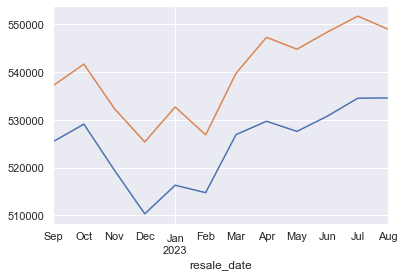

In [29]:
y_test_pred_df.groupby('resale_date')[0].mean().dropna().apply(reverse_transformation).plot()
price_time_test.apply(reverse_transformation).plot();

In [30]:
MAE(y_train_pred_df.groupby('resale_date')[0].mean().dropna().apply(reverse_transformation), price_time_train.apply(reverse_transformation))


3670.2819322425603

In [31]:
MAE(y_test_pred_df.groupby('resale_date')[0].mean().dropna().apply(reverse_transformation), price_time_test.apply(reverse_transformation))


14785.395959269285